## Import libraries

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import functools
import time
import os
import neat
from IPython.display import clear_output

## Constants

In [75]:
WALL      = "x"
FREE_SPACE= "."
SAFE_ZONE = "H"
HIDER     = "h" 
SEEKER    = "s"

CHAR_MAPPING = {
    WALL      : -1,
    FREE_SPACE:  0,
    SAFE_ZONE :  1,
    HIDER     :  2, 
    SEEKER    :  3
}

COLOR_MAPPING = ["black", "white", "blue", "green", "red"]

MAP_SIMPLE_NAME = "map.txt"

ACTIONS = [[0,0], [-1,0], [1, 0], [0,-1], [0, 1]]
VISION = 1
SCENT = 5

STATE_SEEK = 0

## Map

In [76]:
class Map:
        
    def __init__(self,mapname, char_mapping):
        with open(mapname, 'r') as map_file:
            lines = map_file.readlines()
            # width = int(lines[0])
            # height = int(lines[1])
            map_numbers = [[char_mapping[chr] for chr in row[:-1]] for row in lines[2:]]
        self.char_mapping =char_mapping
        self.map = np.array(map_numbers, dtype = np.int32)
        self.scent = np.zeros_like(self.map)
        self.start_hider_pos = np.asarray(np.where(self.map == char_mapping[HIDER])).reshape(2)
        self.start_seeker_pos = np.asarray(np.where(self.map == char_mapping[SEEKER])).reshape(2)
        
        self.map_layout = np.array(map_numbers, dtype = np.int32)
        self.map_layout[self.start_hider_pos[0] ,self.start_hider_pos[1] ] = char_mapping[FREE_SPACE]
        self.map_layout[self.start_seeker_pos[0],self.start_seeker_pos[1]] = char_mapping[FREE_SPACE]
        
        self.reset()
    
    def reset(self):
        self.hider_pos  =self.start_hider_pos
        self.seeker_pos =self.start_seeker_pos
        self.map = np.copy(self.map_layout)
        self.set_map_pos(self.hider_pos,  self.char_mapping[HIDER] )
        self.set_map_pos(self.seeker_pos, self.char_mapping[SEEKER])

    def get_map_layout_pos(self,pos):
        return self.map_layout[pos[0], pos[1]]
    
    def set_map_pos(self,pos, value):
        self.map[pos[0], pos[1]] = value
    
    def get_agent_pos(self, agent):
        return self.hider_pos if agent ==HIDER else self.seeker_pos
    
    def set_agent_pos(self, agent, pos):
        if agent ==HIDER:
            self.hider_pos  =pos
        else:
            self.seeker_pos =pos
    
    def get_percepts(self, agent,vision = 1):
        vision = VISION if agent ==HIDER else VISION
        pos =self.get_agent_pos(self, agent)
        percepts = self.map[
            pos[0] - vision : pos[0] + vision + 1,
            pos[1] - vision : pos[1] + vision + 1
        ]
        return percepts 

    def is_free(self, pos, agent):
        map_pos =self.get_map_layout_pos(pos)
        if (agent == HIDER):
            return (
                map_pos in [self.char_mapping[FREE_SPACE], self.char_mapping[SAFE_ZONE]] and
                np.all(pos != self.seeker_pos)
            )
        else:
            return map_pos in [self.char_mapping[FREE_SPACE]]
            
    def move_agent(self, agent, new_pos):
        pos = self.get_agent_pos(agent)
        self.set_map_pos(pos,self.get_map_layout_pos(pos))
        self.set_map_pos(new_pos,self.char_mapping[agent])
        self.set_agent_pos( agent, new_pos)

    def do_action(self, agent, action):
        pos = self.get_agent_pos(agent)
        new_pos = pos + ACTIONS[action]
        if self.is_free(new_pos, agent):
            self.move_agent(agent, new_pos)
    
    def is_end(self):
        return np.all(self.hider_pos == self.seeker_pos)
            
map = Map(MAP_SIMPLE_NAME,CHAR_MAPPING)

## Map visualization

In [83]:
def plot_map_jupiter_notebook(map:Map,gen):
    clear_output(wait=True)
    plt.figure()
    plt.title(f"Generation {gen}")
    plt.imshow(map.map, cmap = matplotlib.colors.ListedColormap(COLOR_MAPPING))
    plt.show()
    
class Map_plot:
    def __init__(self, map:Map):
        plt.ion()
        self.fig, self.ax = plt.subplots()
        self.img = self.ax.imshow(map.map , cmap = matplotlib.colors.ListedColormap(COLOR_MAPPING))
        
    def plot_map(self,map:Map, gen):
        self.ax.set_title(f"Generation {gen}")
        self.img.set_array(map.map)
        plt.draw()
        self.img.canvas.flush_events()

class Map_log:
    def __init__(self, log_name):
        self.dir = os.path.join("logs",log_name)
        self.log_num = 0 
        self.logs = []
        
    def log_map(self,map:Map,gen):
        self.log_num = gen
        self.logs.append([map.hider_pos,map.seeker_pos])
        
    def save_and_reset(self):
        if not os.path.exists(self.dir):
            os.makedirs(self.dir)
        np.save(os.path.join(self.dir,str(self.log_num)),self.logs)
        self.logs = []

## Evaluation

In [78]:
def eval_map_state(map:Map):
    dist = np.abs(map.hider_pos - map.seeker_pos).sum()

    if map.get_map_layout_pos(map.hider_pos) == CHAR_MAPPING[SAFE_ZONE]:
        state_hide = 0
    elif map.is_end():
        state_hide = -100000
    elif dist == 1:
        state_hide = -1000
    else:
        state_hide = (map.hider_pos**2).sum()

    if  map.is_end():
        state_seek = 100000
    elif dist == 1:
        state_seek = 1000
    else:
        state_seek = 0
    return (state_hide+10, state_seek-10)


## Policies

In [79]:

def random_policy(map:Map, agent, **kwargs):
    return np.random.randint(len(ACTIONS))


def NN_policy(map:Map, agent, **kwargs):
    if agent == SEEKER:
        network = kwargs.get("seek_net")
        pos = kwargs.get("pos_seek")
    else:
        network = kwargs.get("hide_net")
        pos = kwargs.get("pos_hide")

    output = network.activate(map.get_percepts(agent).reshape(-1))
    while not map.is_free(pos, agent):
        output[np.argmax(output)] = -np.inf
    return np.argmax(output)


## Simulation

In [80]:
def simulate_step(map:Map, agent, policy, **kwargs):

    action = policy(map, agent, **kwargs)
    map.do_action(agent, action)      

def simulate(map:Map, map_eval, policy_hide, policy_seek, plot_func=None, num_steps = 100, **kwargs):
    SEEK_STATE = 0
    HIDE_STATE = 0
    map.reset()
    scores = np.zeros(2)
    for step in range(num_steps):

        simulate_step(map, SEEKER, policy_seek, **kwargs)
        if(not map.is_end()):
            simulate_step(map, HIDER, policy_hide, **kwargs)

        if plot_func!=None:
            plot_func(map, kwargs.get("generation"))

        scores += map_eval(map)

        if(map.is_end()):
            break
    return scores


### Simulation test


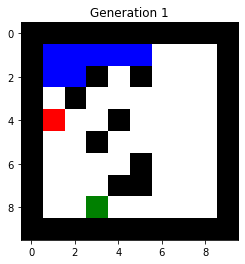

array([3588., -500.])

In [81]:
simulate(
    map, eval_map_state,
    random_policy, random_policy,
    plot_map_jupiter_notebook,
    generation = 1, num_steps=50)

### Log test

In [84]:
log = Map_log("Test")

simulate(
    map, eval_map_state,
    random_policy, random_policy,
    log.log_map,
    generation = 1, num_steps=50)

log.save_and_reset()

In [8]:
#todo fic parttools last two arguments
FIT_SIMULATION_STEPS = 20
def fitness_seek(genomes, config, start_hide, start_seek, default_map_state, hide_net):
    print("FITNESS SEEK")
    for genome_id, genome in genomes:        
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = simulate(default_map_state, start_hide, 
            start_seek, NN_policy, NN_policy, plot_map_jupiter_notebook,
            num_steps = FIT_SIMULATION_STEPS, 
            seek_net = net,  plot = False,
            hide_net = neat.nn.FeedForwardNetwork.create(hide_net, config))[1]

def fitness_hide(genomes, config, start_hide, start_seek, default_map_state, seek_net):
    print("FITNESS HIDE")
    for genome_id, genome in genomes:        
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = simulate(default_map_state, start_hide, 
            start_seek, NN_policy, NN_policy, plot_map_jupiter_notebook,
            num_steps = FIT_SIMULATION_STEPS, 
            seek_net = neat.nn.FeedForwardNetwork.create(seek_net, config), 
            hide_net = net, plot = False)[0]

def run_evolution(config_file, map_env, start_hide, start_seek,  main_it_count = 20):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    seek_pop = neat.Population(config)
    seek_pop.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    seek_pop.add_reporter(stats)
    seek_pop.add_reporter(neat.Checkpointer(5))

    hide_pop = neat.Population(config)
    hide_pop.add_reporter(neat.StdOutReporter(True))
    stats_h = neat.StatisticsReporter()
    hide_pop.add_reporter(stats_h)
    hide_pop.add_reporter(neat.Checkpointer(5))
    #TODO how to init winner
    winner_seek = neat.DefaultGenome(config)
    winner_hide = neat.DefaultGenome(config)
    INTER_IT_COUNT = 10
    POP_LEN = 20
    for it in range(main_it_count):
        
        # Run for up to 300 generations.
        
        fit_seek_fixed = functools.partial(fitness_seek, default_map_state = map_env, start_hide = start_hide, 
            start_seek = start_seek, hide_net = winner_hide)
        winner_seek = seek_pop.run(fit_seek_fixed, INTER_IT_COUNT)
        #TODO how to return whole population ?
        seek_pop = seek_pop.statistics.best_unique_genomes(POP_LEN)

        fit_hide_fixed = functools.partial(fitness_hide, default_map_state = map_env, start_hide = start_hide, 
            start_seek = start_seek, seek_net = winner_seek)
        winner_hide = hide_pop.run(fit_hide_fixed, INTER_IT_COUNT)
        #TODO how to return whole population ?
        hide_pop = hide_pop.statistics.best_unique_genomes(POP_LEN)
        
        simulate(map_env, start_hide, start_seek, 
            NN_policy, NN_policy,
            hide_net = neat.nn.FeedForwardNetwork.create(winner_hide,config), 
            seek_net = neat.nn.FeedForwardNetwork.create(winner_seek, config), num_steps=100, generation = (it + 1) * INTER_IT_COUNT, plot = True)

config_path = 'config-feedforward'
run_evolution(config_path, simple_map, hider_pos, seeker_pos)
#
    ##TODO adjust below
    ## Display the winning genome.
    #print('\nBest genome:\n{!s}'.format(winner))
#
    ## Show output of the most fit genome against training data.
    #print('\nOutput:')
    #winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    ##for xi, xo in zip(xor_inputs, xor_outputs):
    ##    output = winner_net.activate(xi)
    ##    print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))
#
    #node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
    #visualize.draw_net(config, winner, True, node_names=node_names)
    #visualize.draw_net(config, winner, True, node_names=node_names, prune_unused=True)
    #visualize.plot_stats(stats, ylog=False, view=True)
    #visualize.plot_species(stats, view=True)
#
    #p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    #p.run(eval_genomes, 10)


 ****** Running generation 0 ****** 

FITNESS SEEK
Population's average fitness: -200.00000 stdev: 0.00000
Best fitness: -200.00000 - size: (5, 45) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 0.987, standard deviation 0.262
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50   -200.0    0.000     0
Total extinctions: 0
Generation time: 0.121 sec

 ****** Running generation 1 ****** 

FITNESS SEEK
Population's average fitness: -200.00000 stdev: 0.00000
Best fitness: -200.00000 - size: (5, 45) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 1.072, standard deviation 0.242
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    50   -200.0    0.000     1
Total extinctions: 0
Generation time: 0.128 sec (0.125 average)

 ****** Running generation 2 ****** 

FITNESS SEE

AttributeError: 'Population' object has no attribute 'statistics'